# Active mechanisms

## NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/static/docs/neuronpython/index.html

## NMODL
* NEURON Extension to NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl2.html
* NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html#nmodl

### How to compile mechanisms:
1. `nrnivmodl mod.files` in Terminal (or `cd mod.files; nrnivmodl`), OR
2. Use `mknrndll.app` (or equivalent apps in Windows or Linux).

In [4]:
%%bash
cd mod.files
nrnivmodl .

/usr/bin/xcrun
/Users/shhong/Dropbox/CNS_course/2022/a310_cns_2022/class_3/mod.files
-n Mod files:
-n  "./CaT.mod"
-n  "./ConnorStevens.mod"
-n  "./HH2.mod"
-n  "./ca.mod"
-n  "./caL3d.mod"
-n  "./cad.mod"
-n  "./exp2synNMDA.mod"
-n  "./h.mod"
-n  "./kca.mod"
-n  "./kir.mod"
-n  "./km.mod"
-n  "./kv.mod"
-n  "./mease.mod"
-n  "./na.mod"
-n  "./netstim2.mod"
-n  "./wb.mod"


Creating x86_64 directory for .o files.

COBJS=''
 -> Compiling mod_func.c
 -> NMODL .././CaT.mod
(cd "../."; MODLUNIT=/opt/anaconda3/lib/python3.8/site-packages/neuron/.data/share/nrn/lib/nrnunits.lib /opt/anaconda3/lib/python3.8/site-packages/neuron/.data/bin/nocmodl CaT.mod -o "/Users/shhong/Dropbox/CNS_course/2022/a310_cns_2022/class_3/mod.files/x86_64")
 -> NMODL .././ConnorStevens.mod
gcc -O2   -I.   -I/opt/anaconda3/lib/python3.8/site-packages/neuron/.data/include  -I/usr/local/Cellar/open-mpi/4.1.2/include -fPIC -c mod_func.c -o mod_func.o
 -> NMODL .././HH2.mod
(cd "../."; MODLUNIT=/opt/anaconda3/lib/python

Translating CaT.mod into /Users/shhong/Dropbox/CNS_course/2022/a310_cns_2022/class_3/mod.files/x86_64/CaT.c
Translating ConnorStevens.mod into /Users/shhong/Dropbox/CNS_course/2022/a310_cns_2022/class_3/mod.files/x86_64/ConnorStevens.c
Translating HH2.mod into /Users/shhong/Dropbox/CNS_course/2022/a310_cns_2022/class_3/mod.files/x86_64/HH2.c
Notice: VERBATIM blocks are not thread safe
Notice: VERBATIM blocks are not thread safe
Notice: This mechanism cannot be used with CVODE
Notice: This mechanism cannot be used with CVODE
Thread Safe
Translating cad.mod into /Users/shhong/Dropbox/CNS_course/2022/a310_cns_2022/class_3/mod.files/x86_64/cad.c
Translating ca.mod into /Users/shhong/Dropbox/CNS_course/2022/a310_cns_2022/class_3/mod.files/x86_64/ca.c
Translating caL3d.mod into /Users/shhong/Dropbox/CNS_course/2022/a310_cns_2022/class_3/mod.files/x86_64/caL3d.c
Notice: Assignment to the GLOBAL variable, "tadj", is not thread safe
NEURON's CVode method ignores conservation
Notice: Assignment 

### How to load mechanisms:
1. Place `x86_64` directory in the same directory as the simulation, OR
2. Use "File" -> "load dll" in GUI, OR
3. Use `neuron.load_mechanisms('directory name')`.


Now, we first load the necessary modules and create a single compartment cell,

In [5]:
import neuron
from neuron import h, gui
neuron.load_mechanisms("mod.files")

import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Single compartment cell
soma = h.Section(name="soma")
soma.L = 20
soma.diam = 20

# Add a current clamp electrode
ic = h.IClamp(soma(0.5))

Then, we insert the "hh2" mechanism (in `mod.files/HH2.mod`) and check the cells,

In [7]:
soma.insert("hh2")
h.psection()

soma { nseg=1  L=20  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=20}
	insert capacitance { cm=1}
	insert IClamp { del=0 dur=0 amp=0}
	insert hh2 { gnabar_hh2=0.003 gkbar_hh2=0.005 vtraub_hh2=-63}
	insert na_ion { ena=50}
	insert k_ion { ek=-77}
}


1.0

In [11]:
# Prepare a simulation for 300 ms,
h.tstop = 500

# Current injection of 10 pA for 200 ms
ic.delay = 50
ic.dur = 300
ic.amp = 0.005 # 5 pA

In [12]:
# We set the temperature to 35°C to simulate a mammalian neuron,
h.celsius = 35

# Record the time and voltage,
dt_rec = 0.1
t = h.Vector()
v = h.Vector()
t.record(h._ref_t, 0.1)
v.record(soma(0.5)._ref_v, dt_rec)

Vector[4]

Here, we add a `NetCon` object that will monitor the membrane potential of the cell and detect events with `v` crossing -20 mV. Since this `NetCon` does not need to deliver events to anything else, we connect it to `None`. Then, we can record the event times to a vector, which lets us to record spike times, detected by a voltage threshold.

In [13]:
nc = h.NetCon(soma(0.5)._ref_v, None, -20, 0, 1)
tspike = h.Vector()
nc.record(tspike)

0.0

[Text(0.5, 0, 'time (ms)'), Text(0, 0.5, 'v (mv)')]

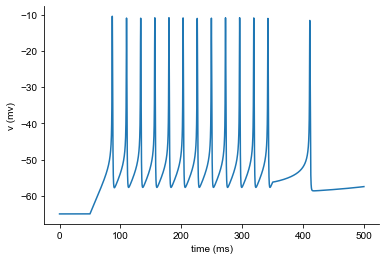

In [14]:
# Run the simulation and plot the result

h.run()

_, ax = plt.subplots()

ax.plot(t, v)
ax.set(xlabel="time (ms)", ylabel = "v (mv)")

Here We print the spike times. Note that we used `.as_numpy` to transform a NEURON `Vector` to a numpy array

In [15]:
print(tspike.as_numpy())

[ 86.325 109.725 132.95  156.175 179.4   202.625 225.85  249.05  272.275
 295.5   318.725 341.95  410.75 ]


## Pyramidal cell example

Now let's simulate the fully active pyramidal cell model. **Please make sure that you restart the kernel at this point.**

In [1]:
import neuron
from neuron import h, gui
import libcell

import numpy as np
import matplotlib.pyplot as plt

First we defined a passive cell,

In [2]:
cell = libcell.L23()

	0 
	1 
	1 
	1 
	1 


In [3]:
neuron.load_mechanisms("mod.files")

True

And then, we call a function in `libcell.py` to embed active mechanisms everywhere,`

In [4]:
libcell.init_active(cell, axon=True, soma=True, dend=True, dendNa=True, dendCa=True)
h.psection()

soma { nseg=7  L=9.26604  Ra=100
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert capacitance { cm=1}
	insert morphology { diam=29.7838}
	insert pas { g_pas=0.000142857 e_pas=-75}
	insert na { gbar_na=1000}
	insert na_ion { ena=60}
	insert kv { gbar_kv=100}
	insert km { gbar_km=2.2}
	insert kca { gbar_kca=3}
	insert k_ion { ek=-90}
	insert ca { gbar_ca=0.5}
	insert it { gbar_it=0.0003}
	insert ca_ion { cai=5e-05 cao=2}
}


1.0

To test the excitability of the cell, we add a current clamp electrode at soma,

In [5]:
ic = h.IClamp(cell.soma(0.5))

Let's define a function to do a virtual current clamp experiment,

In [6]:
def do_current_clamp(current_injected):
    
    # should not forget setting the temperature...
    h.celsius = 35
    
    # Simulation length = 300 ms
    h.tstop = 300

    # Current injection for 200 ms
    ic.delay = 50
    ic.dur = 200
    ic.amp = current_injected


    dt_rec = 0.1
    t = h.Vector()
    v = h.Vector()
    v.record(cell.soma(1)._ref_v, dt_rec)
    t.record(h._ref_t, dt_rec)

    # We set the initial voltage to -75 mV and run the simulation
    h.v_init = -75
    h.init()
    h.run()
    
    # Here we plot the result
    _, ax = plt.subplots()

    ax.plot(t, v)
    ax.set(xlabel="time (ms)", ylabel = "v (mv)")

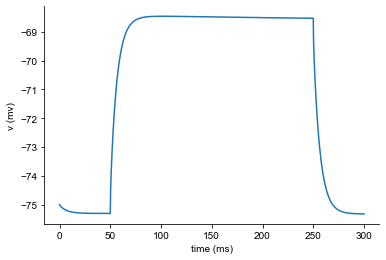

In [15]:
do_current_clamp(0.1) # 100 pA injection; the cell is still in a subthreshold regime

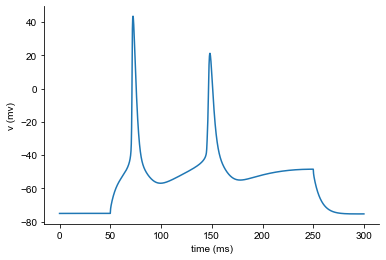

In [17]:
do_current_clamp(0.35) # 350 pA injection will give you spikes

### Adding synapses

Here we will add some synapses to the cell. These functions are copied from `libcell.py` and modified to connect each synapse to external artificial spike generators.

In [7]:
def add_AMPAsyns(model, locs, stims, gmax=1, tau1=0.5, tau2=1):
    """inserts AMPA synapses into model at locs and connect them to stims.
    locs is a list of lists containing two numbers, such as [[0, 0.5]]. The first
    number denotes which dendritic compartement the synapse will be located
    and the second is a relative coordinate. For example, [[0, 0.5]] will embed
    one synapse at model.dends[0](0.5). gmax is a maximal conductance in uS.
    tau1 and tau2 are a rising and decay time constant in ms.
    """
    # we store synapses and NetCons in a list
    model.AMPAlist = []
    model.ncAMPAlist = []
    
    # set in nS and convert to muS
    gmax = gmax/1000.
    
    for loc, stim in zip(locs, stims):
        # an AMPA synapse is `Exp2Syn` with a reversal potential = 0 mV
        AMPA = h.Exp2Syn(float(loc[1]), sec=model.dends[int(loc[0])])
        AMPA.tau1 = tau1
        AMPA.tau2 = tau2
        
        # connect stim to the synapse
        NC = h.NetCon(stim, AMPA, 0, 0, gmax)
        model.AMPAlist.append(AMPA)
        model.ncAMPAlist.append(NC)

In [8]:
def add_NMDAsyns(model, locs, stims, gmax=1, tau1=2, tau2=20):
    """inserts NMDA synapses into model at locs and connect them to stims."""
    model.NMDAlist = []
    model.ncNMDAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc, stim in zip(locs, stims):
        # an NMDA synapse
        NMDA = h.Exp2SynNMDA(float(loc[1]), sec=model.dends[int(loc[0])])
        NMDA.tau1 = tau1
        NMDA.tau2 = tau2
        NC = h.NetCon(stim, NMDA, 0, 0, gmax)
        x = float(loc[1])
        model.NMDAlist.append(NMDA)
        model.ncNMDAlist.append(NC)

In [9]:
def add_GABAsyns(model, locs, stims, gmax=0.5, tau1=0.1, tau2=4, rev=-80):
    """insetrs GABA synapses into model at locs and connect them to stims."""
    model.GABAlist = []
    model.ncGABAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc, stim in zip(locs, stims):
        # a GABA synapse is `Exp2Syn` with a reversal potential = rev mV 
        # (default value = -80 mV)
        GABA = h.Exp2Syn(float(loc[1]), sec=model.dends[int(loc[0])])
        GABA.tau1 = tau1
        GABA.tau2 = tau2
        GABA.e = rev
        
        NC = h.NetCon(stim, GABA, 0, 0, gmax)
        model.GABAlist.append(GABA)
        model.ncGABAlist.append(NC)

Lets add an AMPA+NMDA synapse at cell.dend\[0\](0.5) and connect it to an artificial spike generator.

In [26]:
# location = cell.dends[0](0.5)
locs = [[0, 0.5]]

# spiking frequency = 10 Hz, ISI = 1000/10 = 10 ms
fexc = 10

exc_stims = []
for loc in locs:
    exc_stims.append(h.NetStimFD()) # An articifial spike generator
    exc_stims[-1].noise = 0 # no noise
    exc_stims[-1].start = 150 # start from 150 ms
    exc_stims[-1].duration = h.tstop
    exc_stims[-1].interval = 1000./fexc # set ISI

# Add an AMPA synapse connected to exc_stims
add_AMPAsyns(cell, locs, exc_stims)
# Add an NMDA synapse at the same location, also connected to exc_stims
add_NMDAsyns(cell, locs, exc_stims)


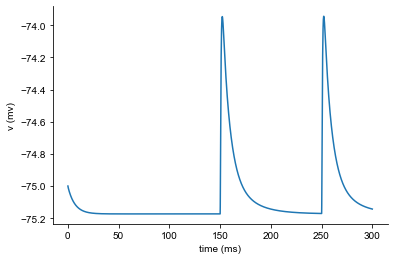

In [27]:
do_current_clamp(0.0) # Run a simulation with no current injection

Now let's try many more synapses, inserted at random locations! We first make a function to create random locations in the cell's dendrites.

In [32]:
len(cell.dends)

104

In [10]:
def genRandomLocs(model, nsyn):
    """generates nsyn random locations distributed in model.dends."""
    locs = []
    for s in np.arange(0,nsyn):
        dend = np.random.randint(low=0, high=len(model.dends))
        pos = np.random.uniform()
        locs.append([dend, pos])
    return locs

In [11]:
genRandomLocs(cell, 10)

[[63, 0.03018639997266881],
 [3, 0.09165044785638643],
 [55, 0.04152557634296117],
 [66, 0.6088918625342595],
 [74, 0.4976199426940604],
 [35, 0.28807053169271757],
 [4, 0.32084783333799716],
 [1, 0.35850014416637477],
 [30, 0.21622918751352815],
 [47, 0.9677029878109051]]

And then, we create 100 excitatory and 20 inhibitory synapse locations.

In [12]:
n_exc = 100
n_inh = 20

exc_locs = genRandomLocs(cell, n_exc)
inh_locs = genRandomLocs(cell, n_inh)
inh_locs

[[53, 0.7600026926816007],
 [95, 0.2743492211354557],
 [0, 0.43760947328974265],
 [94, 0.8039439424086952],
 [44, 0.4829008151643651],
 [83, 0.5057687720228087],
 [38, 0.7080907113966173],
 [51, 0.743624977547078],
 [32, 0.5802217051677053],
 [21, 0.7412349676961771],
 [66, 0.6165100524694088],
 [59, 0.5807023415010472],
 [1, 0.8468586390619992],
 [58, 0.6112576722070437],
 [42, 0.044406201081019114],
 [24, 0.7385035693569602],
 [29, 0.7717387940136021],
 [60, 0.6717978363326106],
 [38, 0.1530505002654987],
 [29, 0.07845349414856406]]

We connect the excitatory synapses to spike generators, Poisson firing at 10 Hz. The inhibitory ones will be connected to another set of spike generators firing at 40 Hz.

In [15]:
fexc = 30 # 30 Hz
exc_stims = []
for loc in exc_locs:
    exc_stims.append(h.NetStimFD())
    exc_stims[-1].noise = 1 # maximally noisy stimulus
    exc_stims[-1].start = 0 # start from 0
    exc_stims[-1].duration = h.tstop
    exc_stims[-1].interval = 1000./fexc

add_AMPAsyns(cell, exc_locs, exc_stims)
add_NMDAsyns(cell, exc_locs, exc_stims)


# inhibitory stims
finh = 40 # 40 Hz
inh_stims = []
for loc in inh_locs:
    inh_stims.append(h.NetStimFD())
    inh_stims[-1].noise = 1 # maximally noisy stimulus
    inh_stims[-1].start = 0 # start from 0
    inh_stims[-1].duration = h.tstop
    inh_stims[-1].interval = 1000./fexc

add_GABAsyns(cell, inh_locs, inh_stims)

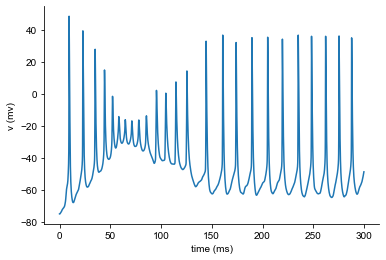

In [16]:
do_current_clamp(-0.) # Run a simulation with no current injection